In [103]:
path = "PRIMNET/FINGER"

from path_handler import get_BASERDIR
import os
BASEDIR, RUNMODE = get_BASERDIR(".")

if BASEDIR.absolute().name == "control":
    os.chdir("..")
os.getcwd()

Running on Jupyter...


'/home/taerim/sOftrobot/PRIMNET-V2/code'

In [104]:
# %%
from pathlib import Path
import sys

try: 
    get_ipython().__class__.__name__
    BASEDIR = Path().absolute()
except: BASEDIR = Path(__file__).parent

sys.path.append(str(BASEDIR))
import torch
from torch import nn
import argparse

import numpy as np
from utils import dataloader
from utils.initalize import INITALZE_EVEN_JOINTS
from utils.update import  update_primnet, update_fc_primnet, update_pcc_primnet


import os
import random
from pathlib import Path
import wandb
import time
import json

from utils.tools import set_seed, set_wandb, print_log_dict, prefix_dict, average_dict
from utils.path_handler import JUPYTER, RUN, DEBUG, get_BASERDIR
from utils.args import read_ARGS
from utils.logger import CSVLogger,ask_and_make_folder
from utils.tools import cast_numpy

from configs.template import PRIMNET_ARGS_TEMPLATE, FC_PRIMNET_ARGS_TEMPLATE, PCC_PRIMNET_ARGS_TEMPLATE
from model.PRIMNET import PRIMNET
from model.FC_PRIMNET import FC_PRIMNET
from typing import Union

from utils.dataloader import get_dataset, Sampler

In [105]:
BASEDIR, RUNMODE = get_BASERDIR(os.getcwd())
args = read_ARGS((BASEDIR/'results'/path/"args.py").absolute())
args

Running on Jupyter...


ARGS(MODEL='PRIMNET', EVEN_JOINTS=True, WANDB=True, pname='PRIMNET_v2.2', runname='FINGER', DATASET='FINGER', TPOSE=((0, 0, 0.12),), LOAD_WEIGHTPATH=None, SAVE_PERIOD=1, TEST_PERIOD=1, EVEN_JOINT=True, p_offset_std=0.1, rpy_offset_std=0.01, axis_std=0.1, OUTPUT_NORMALIZE=False, seed=0, hdim=(16, 16), motor_embed_dim=4, lr=0.0015, lrd=0.95, wd=0.0, w_vec=0.005, epochs=2000, focus_ratio=0.0, data_ratio=1.0, n_workers=2, batch_size=64, joint_seqs=('F', 'R', 'P', 'R', 'R', 'P', 'R'), marker_num=1, motor_dim=2)

In [107]:
if args.MODEL == 'PRIMNET':
    model = PRIMNET(args=args).to(args.device)
elif args.MODEL == 'FC_PRIMNET':
    model = FC_PRIMNET(args=args).to(args.device)

model.load_state_dict(torch.load(BASEDIR/'results'/path/"weights/epoch_2000.pth"))

<All keys matched successfully>

In [108]:
def forward_motor(model:PRIMNET, motor_control):     
    motor_control = model.normalize(motor_control)
    
    # Forward
    act_embeds = model.ACT_EMBED.layers(motor_control)
    q_values = model.FK_LAYER.forward_q(act_embeds)
    joint_se3 = model.FK_LAYER.forward_kinematics(q_values)
    
    return model.t2p(joint_se3, OUTPUT_NORMALIZE=False)



## Forward Kinematics

In [145]:
train_dataset,val_dataset,test_dataset,ext_dataset  = get_dataset(f"../dataset/FINGER.json", args.data_ratio)



In [146]:
model.motor_mean, model.motor_std, model.position_mean, model.position_std

(tensor([  0.7379, -50.0518]),
 tensor([557.4562, 569.9876]),
 tensor([[0.],
         [0.],
         [0.]]),
 tensor([[1.],
         [1.],
         [1.]]))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

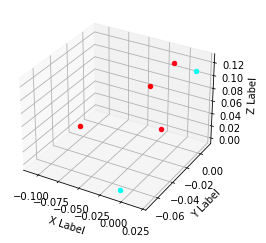

In [147]:
from matplotlib import pyplot as plt
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)



fig = plt.figure()
ax = fig.add_subplot(projection='3d')

length = 3
start_point = random.randint(0, 1000)
cmap = get_cmap(len(train_dataset.position[start_point:start_point+length]))

for i, (pos,actuation) in enumerate(
    zip(train_dataset.position[start_point:start_point+length],
        train_dataset.motor_control[start_point:start_point+length])):
    
    
    pos_ = pos[0,:,0]
    ax.scatter(pos_[0], pos_[1], pos_[2], c=cmap(i))
    
    actuation = actuation/10_000
    ax.scatter(actuation[0], actuation[1], 0, c=cmap(i))
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

plt.show()
    

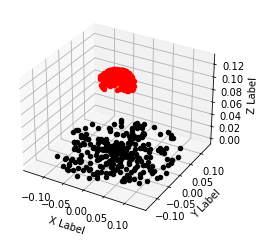

In [148]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')


for pos in train_dataset.position:
    pos_ = pos[0,:,0]
    ax.scatter(pos_[0], pos_[1], pos_[2], c='r')
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    


for actuation in train_dataset.motor_control:
    actuation = actuation/10_000
    ax.scatter(actuation[0], actuation[1], 0, c='k')

plt.show()
    

In [112]:
rest_pos = model(torch.zeros(1,2).to(torch.float))[0,-1].detach().numpy()

In [113]:
ps[0]

array([ 0.1005518 ,  0.23372969, -0.09769266], dtype=float32)

In [164]:
idx = 4

train_dataset.motor_control[idx], train_dataset.position[idx]

(tensor([-179.2570, 1159.7443]),
 tensor([[[-0.0455],
          [ 0.0040],
          [ 0.1131]]]))

tensor([[ -586.7253, -1184.5509]])
tensor([ 0.0275, -0.0127,  0.1068])


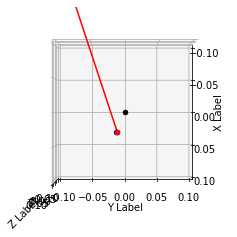

tensor([[271.3662,   9.9153]])
tensor([-0.0034,  0.0137,  0.1249])


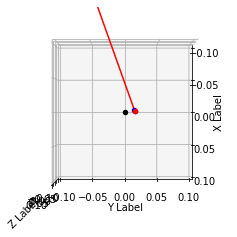

tensor([[ 347.9689, -847.2230]])
tensor([0.0224, 0.0074, 0.1144])


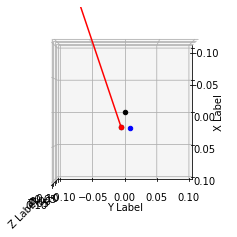

tensor([[382.8284, 379.2530]])
tensor([-0.0180,  0.0155,  0.1222])


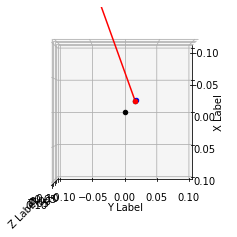

tensor([[  16.0592, -369.3695]])
tensor([0.0112, 0.0048, 0.1226])


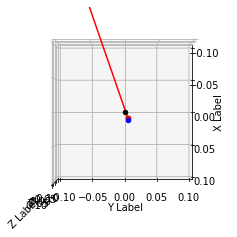

tensor([[441.0236, 347.2102]])
tensor([-0.0165,  0.0200,  0.1216])


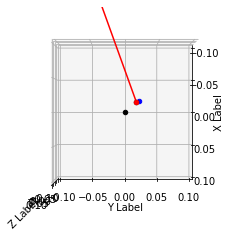

tensor([[ 428.9936, -326.5781]])
tensor([0.0078, 0.0159, 0.1206])


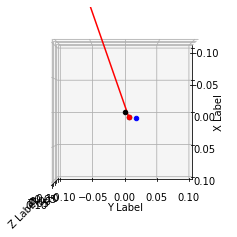

tensor([[ 709.6611, 1059.1346]])
tensor([-0.0384,  0.0238,  0.1116])


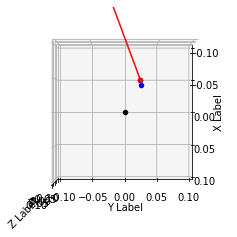

tensor([[701.2166, 552.1345]])
tensor([-0.0246,  0.0260,  0.1171])


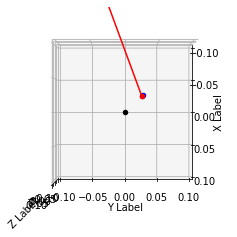

tensor([[-954.2388,  103.6578]])
tensor([-0.0137, -0.0250,  0.1161])


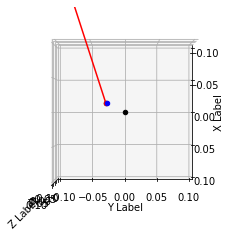

In [119]:
from matplotlib import pyplot as plt


for idx in range(10,20):

    motor_control = train_dataset.motor_control[idx][None,:]
    print(motor_control)
    target_position = train_dataset.position[idx].flatten()
    print(target_position)

    ps = model(motor_control)[0].detach().cpu().squeeze(-1).numpy()
    # ps[-1,:], target_position

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(0,0,0,color='k')
    i = 0
    for p in ps:
        i = i +1
        ax.scatter(p[0], p[1],p[2], color = 'k', alpha = i *0.1 + 0.3)
    
    ax.scatter(p[0], p[1],p[2], color = 'r', alpha = 1)

    for p_fr, p_to in zip(ps[:-1], ps[1:]):
        ax.plot([p_fr[0], p_to[0]], [p_fr[1], p_to[1]], [p_fr[2], p_to[2]], color="red")

    ax.scatter(target_position[0], target_position[1], target_position[2], color='b')

    ax.set_xlim(-0.10, 0.10)
    ax.set_ylim(-0.10, 0.10)
    ax.set_zlim(-0.10, 0.10)
    
    # name x,y,z label to ax
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    
    ax.view_init(elev=90, azim=0)

    plt.show()




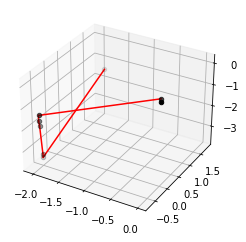

array([-0.00394762,  0.01574558,  0.12642395], dtype=float32)

In [116]:
motor_control = torch.FloatTensor([1000,0]).unsqueeze(0)
ps = model(motor_control)[0].detach().cpu().squeeze(-1).numpy()

from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(0,0,0,color='k')

i = 0
for p in ps:
    i = i +1
    ax.scatter(p[0], p[1],p[2], color = 'k', alpha = i *0.1)

for p_fr, p_to in zip(ps[:-1], ps[1:]):
    ax.plot([p_fr[0], p_to[0]], [p_fr[1], p_to[1]], [p_fr[2], p_to[2]], color="red")

# ax.set_xlim(-0.2, 0.2)
# ax.set_ylim(-0.2, 0.2)
# ax.set_zlim(-0.2, 0.2)
plt.show()

# print(ps[-1,:,0])
ps[-1]

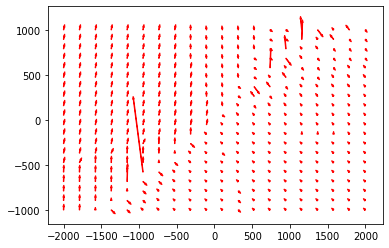

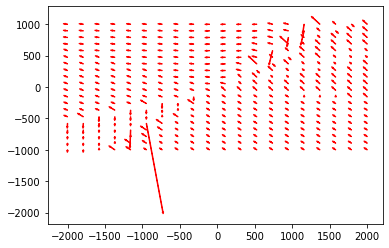

In [151]:
from jacobian import jacobian
from functools import partial

def forward_soro(soro,actuation):
    ps = soro(actuation)
    pos_EE = ps[:,-1,0:2,0]

    return pos_EE

# plot jacobian field

x = torch.linspace(-1000, 1000, 20)
y = torch.linspace(-1000, 1000, 20)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')

for (x,y) in zip(grid_x.flatten(), grid_y.flatten()):
    actuation = torch.FloatTensor([x,y]).reshape(1,-1)
    jac, pos_EE = jacobian(partial(forward_soro,model), actuation)
    jac_act1 = jac[0,:,0,0] * 8e5

    # plt plot arrow on position (x,y) to (x+jac_act[0], y+jac_act[1]))
    # plt.arrow(x,y, jac_act1[0], jac_act1[1], color='r', alpha=1)
    # change arrow width to 1
    plt.arrow(x,y, jac_act1[0], jac_act1[1], color='r', alpha=1, width=7)

plt.show()    

for (x,y) in zip(grid_x.flatten(), grid_y.flatten()):
    actuation = torch.FloatTensor([x,y]).reshape(1,-1)
    jac, pos_EE = jacobian(partial(forward_soro,model), actuation)
    jac_act2 = jac[0,:,0,1] * 8e5

    # plt plot arrow on position (x,y) to (x+jac_act[0], y+jac_act[1]))
    # plt.arrow(x,y, jac_act1[0], jac_act1[1], color='r', alpha=1)
    # change arrow width to 1
    plt.arrow(x,y, jac_act2[0], jac_act2[1], color='r', alpha=1, width=7)

plt.show()    

In [20]:
ps

array([[[-1.9070978e+00],
        [ 1.7842922e+00],
        [-1.3818427e+00]],

       [[-2.0818133e+00],
        [-4.2184770e-01],
        [-3.5543365e+00]],

       [[-2.0622771e+00],
        [-4.0978503e-01],
        [-3.3979957e+00]],

       [[-1.9421979e+00],
        [-6.6769642e-01],
        [-1.6843398e+00]],

       [[-1.9440267e+00],
        [-6.5659124e-01],
        [-1.5001571e+00]],

       [[-1.9501210e+00],
        [-6.6574293e-01],
        [-1.3057662e+00]],

       [[ 8.8453293e-05],
        [ 9.0118051e-03],
        [ 1.2641597e-01]]], dtype=float32)